# Attack examples

In [1]:
import os
import logging
import numpy as np
import pylab as plt
%matplotlib inline

logging.getLogger('matplotlib.font_manager').disabled = True

os.chdir("c:\\Users\\simonr04\\git\\GRAIMatter")
from data_preprocessing.data_interface import get_data_sklearn

logging.basicConfig(level = logging.WARNING)


FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\simonr04\\git\\GRAIMatter'

In [ ]:
logging.debug(os.getcwd())

In [3]:
DATASET_NAME = "mimic2-iaccd"
X, y = get_data_sklearn(DATASET_NAME)
# Choose some features (we don't need all of them)
FEATURES = [
    "age", "gender_num", "bmi", "day_icu_intime_num", "liver_flg", "copd_flg"
]
subX = X[FEATURES].copy()

# Round bmi to an integer
subX['bmi'] = subX['bmi'].astype(int)
subX['age'] = subX['age'].astype(int)

INFO:c:\Users\simonr04\git\GRAIMatter\data_preprocessing\data_interface.py:DATASET FOLDER = c:\Users\simonr04\git\GRAIMatter\data
INFO:c:\Users\simonr04\git\GRAIMatter\data_preprocessing\data_interface.py:Loading mimic2-iaccd
INFO:c:\Users\simonr04\git\GRAIMatter\data_preprocessing\data_interface.py:Preprocessing


## Example 1: Instance based models

This is an example of the danger of instance based models to **white box attacks**. Instance based models must store exact copies of training examples in order to function. This is an obvious disclosure risk.

Here we train a very popular instance based model (a Support Vector Machine), such that it is able to predict xxxxxxx etc

We start by loading the data, splitting it into two sets, and then training the model. We show the model performance via a ROC curve. This is just to show that the model is able to do something (lines above the dashed line show performance better than guessing).

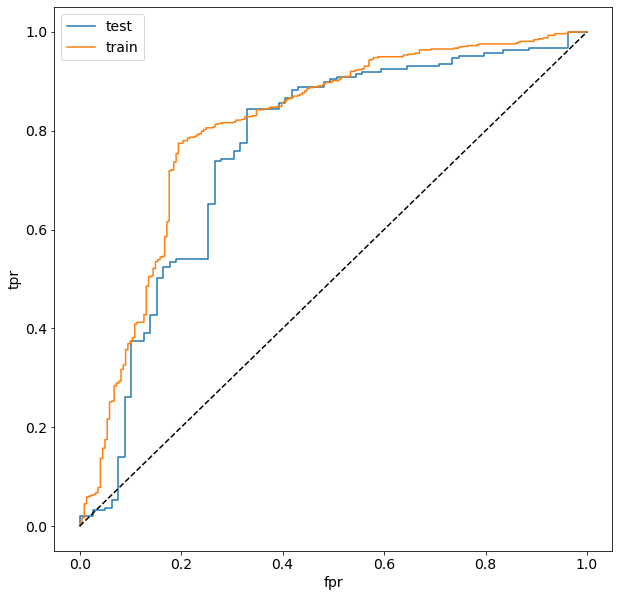

In [4]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
font = {'size': 14}
plt.rc('font', **font)
train_X, test_X, train_y, test_y = train_test_split(subX.values, y.values.flatten())
svm = SVC(probability=True, gamma=.01)
svm.fit(train_X, train_y)
train_probs = svm.predict_proba(train_X)
test_probs = svm.predict_proba(test_X)
plt.figure(figsize=(10, 10))
fpr, tpr, _ = roc_curve(test_y, test_probs[:, 1])
plt.plot(fpr, tpr, label='test')
fpr, tpr, _ = roc_curve(train_y, train_probs[:, 1])
plt.plot(fpr, tpr, label='train')
plt.legend()
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.plot([0, 1], [0, 1], 'k--')


The python object `svm` includes _exact_ copies of some of the data examples. Details in the next cell.

In [5]:
n_support_vectors = len(svm.support_vectors_)
n_total = len(train_X)
print(f"In this example, the SVM has stored exact copies of {n_support_vectors} of the original data rows (out of {n_total} total rows)")

In this example, the SVM has stored exact copies of 441 of the original data rows (out of 798 total rows)


Without these, the SVM won't work. They are immediately accessible with access to the `svm` object. For example, here are the top 5, and the same rows from the training data for comparison:

In [6]:
NTOP = 5
for i in range(NTOP):
    sv_idx = svm.support_[i]
    sv = svm.support_vectors_[i]
    original = train_X[sv_idx, :]
    print(f"EXAMPLE {i}")
    print("\t Original:\t", original)
    print("\t Stored:\t", sv)

EXAMPLE 0
	 Original:	 [46.  1. 39.  5.  0.  0.]
	 Stored:	 [46.  1. 39.  5.  0.  0.]
EXAMPLE 1
	 Original:	 [36.  1. 26.  5.  0.  0.]
	 Stored:	 [36.  1. 26.  5.  0.  0.]
EXAMPLE 2
	 Original:	 [67.  1. 19.  4.  0.  0.]
	 Stored:	 [67.  1. 19.  4.  0.  0.]
EXAMPLE 3
	 Original:	 [55.  0. 19.  6.  0.  0.]
	 Stored:	 [55.  0. 19.  6.  0.  0.]
EXAMPLE 4
	 Original:	 [87.  0. 24.  7.  0.  0.]
	 Stored:	 [87.  0. 24.  7.  0.  0.]


Note that this kind of issue with instance based models is **not** an issue with black box access, where the attacker does not have direct access to the python `svm` object.

## Black box training data extraction

Here we again use an SVM, but look at a different vulnerability that can effect **all** trained models.

A standard machine learning model will be trained to make _predictions_ on unseen data. It is very easy to inadvertantly train a model that gives more _confident_ predictions to examples in the training set than examples it has not seen before (similar to a student giving more confident answers to exam questions they've seen before than those they haven't).

An attacker can make use of this property to attempt to recreate training data.

The example below shows this.

An attacker can _use_ the model to make predictions (i.e. they can present new inputs and observe the predictions, and hence their confidence).

In this case, the attacker generates lots of posible input values (in fact, in this example, we can generater all possible combinations) and asks the model for its predictions.

The attacker then places a threshold on the model's confidence. If the model's confidence value is above this threshold, the attacker predicts that that combination of input values **was** in the training set. If the confidence is below, the attacker predicts that it wasn't.

If an attacker correctly predicts an input from the training set, they have effectively extracted information from the TRE in which the model has been created that they shouldn't be able to.

We can assess the success of the attack by looking at two quantities -- the number of times they correctly predict something was in the training set (True Positives; TP) and the number of times they predict something was in the training set when in fact it wasn't (False Positives; FP).

A successful attack should have a much higher number of TPs than FPs (someone just guessing would get some TPs now and again, but would also get a **lot** of FPs.)

We start by training the model. Note that to make the example really clear, we've trained a pretty bad model. It performs really well on data its seen before (orange line is way above dashed line) but fairly poorly on new data (blue line close to dashed line) (like our student just memorising the answers to past papers without really understanding...they'll do really well if the exam is identical to past ones, and pretty badly otherwise)

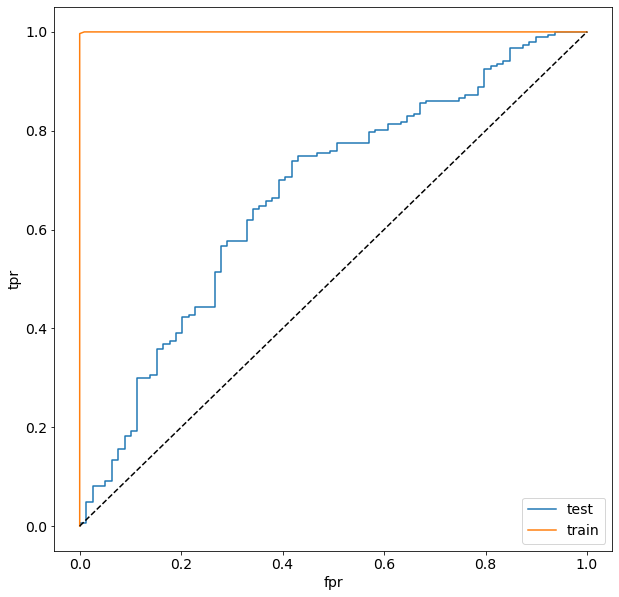

In [15]:
bad_svm = SVC(probability=True, gamma=1.)
bad_svm.fit(train_X, train_y)
train_probs = bad_svm.predict_proba(train_X)
test_probs = bad_svm.predict_proba(test_X)
plt.figure(figsize=(10, 10))
fpr, tpr, _ = roc_curve(test_y, test_probs[:, 1])
plt.plot(fpr, tpr, label='test')
fpr, tpr, _ = roc_curve(train_y, train_probs[:, 1])
plt.plot(fpr, tpr, label='train')
plt.legend()
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.plot([0, 1], [0, 1], 'k--')

unique_vals = {}
for c in subX.columns:
    unique_vals[c] = subX[c].unique()



Find all of the combinations of examples in the data set. We assume the attacker knows this (it would be easy to know). Note that in reality, the attacker would use a smarter optimisation routine to optimise the examples. We just enumerate them here because the dataspace is small.

In [16]:
unique_vals = {}
for c in subX.columns:
    unique_vals[c] = subX[c].unique()

Compute predictions at _all_ possible inputs

In [17]:
# Loop over all unique vals and compute predictions
from tqdm.contrib.itertools import product
all_combinations = product(*unique_vals.values())
l = np.array(list(all_combinations))
pred_probs = bad_svm.predict_proba(l)

100%|██████████| 237440/237440 [00:00<00:00, 1775300.31it/s]


Now we attack. In particular
1. The attacker takes, for each example, the maximum probability. I.e. if the model provides predictive probabilities [0.8, 0.2] for the two classes, the max would be 0.8. If [0.3, 0.7], it would be 0.7.
1. The attacker decides they have time to look at 10000 combinations.
1. Each combination may be in the training set, or may not.
1. The attacker uses the following rule to _predict_ if the point is from the training set:
    - If the max probability is >0.75, predict it was.
    - If the max probability is <= 0.75, predict it wasn't

The code below runs this. Every 100 examples, it reports how well the attacker is doing:
TP = **T**rue **P**ositives -- combinations of inputs that the attacker predicts were in the training set that were in the training set.
FP = **F**alse **P**ositives -- combinations of inputs that the attacker predicts were in the training set that were not in the training set.

It's important to consider both. If an attacker guesses, they will be right some of the time. An attack can only be considered successful if they can get high numbers of TPs with low numbers of FPs.


In [18]:
N_CHECK = 10000
def easy_attack(pred_probs):
    THRESH = 0.75
    max_prob = pred_probs.max(axis=1)
    TN = 0
    TP = 0
    FN = 0
    FP = 0
    REPORT_IT = 100 # report every 100

    true_labels = []

    for n in range(N_CHECK):
        # See if this example is in the training set
        di = ((train_X - l[n, :])**2).sum(axis=1)
        mi = di.argmin()
        if di[mi] == 0:
            in_train = True
            true_labels.append(1)
        else:
            in_train = False
            true_labels.append(0)
        if max_prob[n] >= THRESH:
            # We predict this is in the training set -- are we correct?
            if in_train:
                TP += 1
            else:
                FP += 1
        else:
            if in_train:
                FN += 1
            else:
                TN += 1
        if n % REPORT_IT == 0:
            print(f"Tried {n} combinations. TP = {TP}, FP = {FP}")

    true_labels = np.array(true_labels)
    return true_labels, max_prob

true_labels_bad, max_prob_bad = easy_attack(pred_probs)

Tried 0 combinations. TP = 0, FP = 0
Tried 100 combinations. TP = 2, FP = 21
Tried 200 combinations. TP = 3, FP = 32
Tried 300 combinations. TP = 4, FP = 36
Tried 400 combinations. TP = 4, FP = 40
Tried 500 combinations. TP = 4, FP = 43
Tried 600 combinations. TP = 4, FP = 50
Tried 700 combinations. TP = 4, FP = 50
Tried 800 combinations. TP = 4, FP = 51
Tried 900 combinations. TP = 4, FP = 53
Tried 1000 combinations. TP = 4, FP = 53
Tried 1100 combinations. TP = 5, FP = 53
Tried 1200 combinations. TP = 5, FP = 53
Tried 1300 combinations. TP = 5, FP = 54
Tried 1400 combinations. TP = 5, FP = 54
Tried 1500 combinations. TP = 5, FP = 55
Tried 1600 combinations. TP = 6, FP = 68
Tried 1700 combinations. TP = 8, FP = 77
Tried 1800 combinations. TP = 11, FP = 87
Tried 1900 combinations. TP = 11, FP = 93
Tried 2000 combinations. TP = 12, FP = 96
Tried 2100 combinations. TP = 14, FP = 107
Tried 2200 combinations. TP = 15, FP = 107
Tried 2300 combinations. TP = 15, FP = 110
Tried 2400 combinati

We can see that the attacker has been very successful. Out of trying 10,000 different inputs, they have predicted that 52 of them were in the training set, and all in fact were. In essence, the attacker **has extracted sensitive data from the model that should have remained in the TRE**.

Alternative output as suggested by Jim.
Aim is to compute the TP, TN, FP, FN at a range of _tunable decision thresholds_.


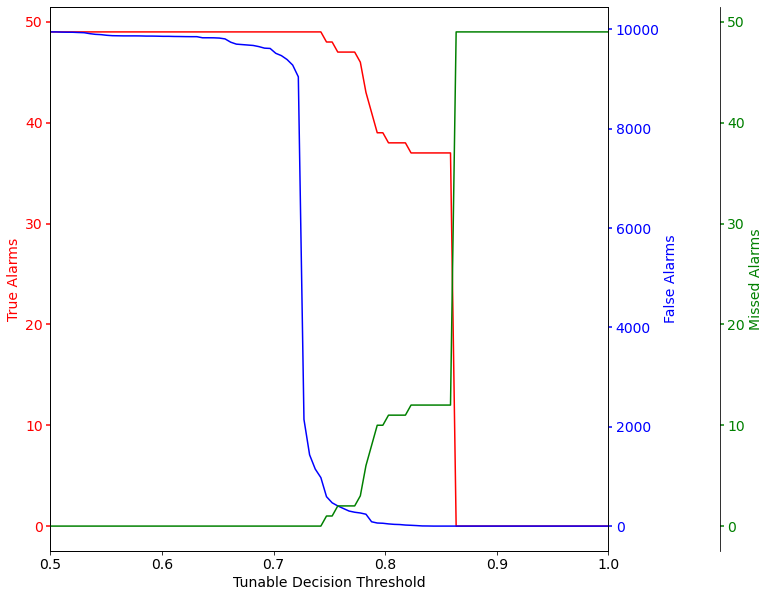

In [25]:
def jim_plot(probs, labels, xl=[0.5, 1.0], n_thresh=100, legend=False):
    thresholds = np.linspace(0.5, 1, n_thresh)
    FP = []
    TP = []
    FN = []
    for th in thresholds:
        pos = 1*(probs >= th)
        TP.append((pos * labels).sum())
        FP.append((pos * (1 - labels)).sum())
        FN.append(((1 - pos) * labels).sum())

    _, ax = plt.subplots(figsize=(10, 10))
    twin1 = ax.twinx()
    twin2 = ax.twinx()
    p1, = ax.plot(thresholds, TP, 'r', label="True Alarms")
    p2, = twin1.plot(thresholds, FP, 'b', label="False Alarms")
    p3, = twin2.plot(thresholds, FN, 'g', label="Missed Alarms")
    
    if legend:
        ax.legend(handles=[p1, p2, p3])
    ax.set_xlabel("Tunable Decision Threshold")

    tkw = dict(size=4, width=1.5)
    ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
    twin1.tick_params(axis='y', colors=p2.get_color(), **tkw)
    twin2.tick_params(axis='y', colors=p3.get_color(), **tkw)

    twin2.spines.right.set_position(("axes", 1.2))
    ax.set_xlim(xl)
    ax.set_ylabel("True Alarms", color=p1.get_color())
    twin1.set_ylabel("False Alarms", color=p2.get_color())
    twin2.set_ylabel("Missed Alarms", color=p3.get_color())


jim_plot(max_prob_bad[:N_CHECK], true_labels_bad)

This plot shows the performance that the attacker can get by varying the threshold (on the confidence in predictions) that they use to predict if an example is from the training set or not. As the threshold increases (left to right), the attacker predicts fewer examples as coming from the training set.

The red curve (left-hand y-axis) shows the number of _True Alarms_, that is, the number of examples that the attacker predicts are from the training set that are indeed from the training set. The blue line (first right-hand y-axis) shows the number of _False Alarms_ -- the number of examples that the attacker predicts as being from the training set that are not in the training set. What is important here is to determine if there is a region when the red line is high (lots of correct predictions for examples in the training set) whilst the blue line is low (the attacker doesn't predict many examples that were not in the training set as being in the training set). If such a region exists (as it does here, between thresholds of about 0.75 and 0.9), we can conclude that a successful attack is possible.

The green line depitcs the number of _Missed Alarms_. These are the number of examples that were in the trainign set that the attacker predicts were not.

Clearly this is a somewhat contrived example. In a real system, it's unlikely that:
1. it would be possible to enumerate all parameter combinations
1. exact matches would be found by randomly trying combinations
However -- the same principle can be successfully applied to realistic problems through **optimisation**. Rather than trying lots of combinations, the attacker tries an initial random combination. They then try and change that combination slightly to make the model more confident. If this is repeated many times, the example will (if the model is vulnerable to attack in this way) eventually get to a point where its confidence cannot be increased any more. At that point, if the confidence is above the threshold, it is likely that the attacker has reached a training example.

## Mitigating black box attacks

How can we mitigate such models? We train them better. Let's try the same attack on our original SVM (the one we used for the white box example at the top)

Tried 0 combinations. TP = 1, FP = 0
Tried 100 combinations. TP = 2, FP = 74
Tried 200 combinations. TP = 3, FP = 141
Tried 300 combinations. TP = 3, FP = 207
Tried 400 combinations. TP = 3, FP = 253
Tried 500 combinations. TP = 3, FP = 281
Tried 600 combinations. TP = 3, FP = 368
Tried 700 combinations. TP = 3, FP = 440
Tried 800 combinations. TP = 3, FP = 540
Tried 900 combinations. TP = 3, FP = 630
Tried 1000 combinations. TP = 3, FP = 667
Tried 1100 combinations. TP = 3, FP = 738
Tried 1200 combinations. TP = 3, FP = 766
Tried 1300 combinations. TP = 3, FP = 805
Tried 1400 combinations. TP = 3, FP = 830
Tried 1500 combinations. TP = 3, FP = 874
Tried 1600 combinations. TP = 4, FP = 947
Tried 1700 combinations. TP = 5, FP = 1008
Tried 1800 combinations. TP = 7, FP = 1082
Tried 1900 combinations. TP = 7, FP = 1115
Tried 2000 combinations. TP = 8, FP = 1155
Tried 2100 combinations. TP = 10, FP = 1243
Tried 2200 combinations. TP = 10, FP = 1315
Tried 2300 combinations. TP = 10, FP = 14

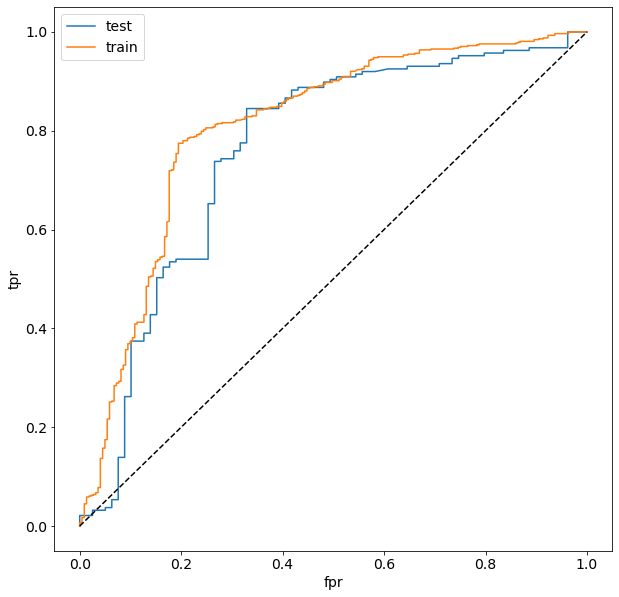

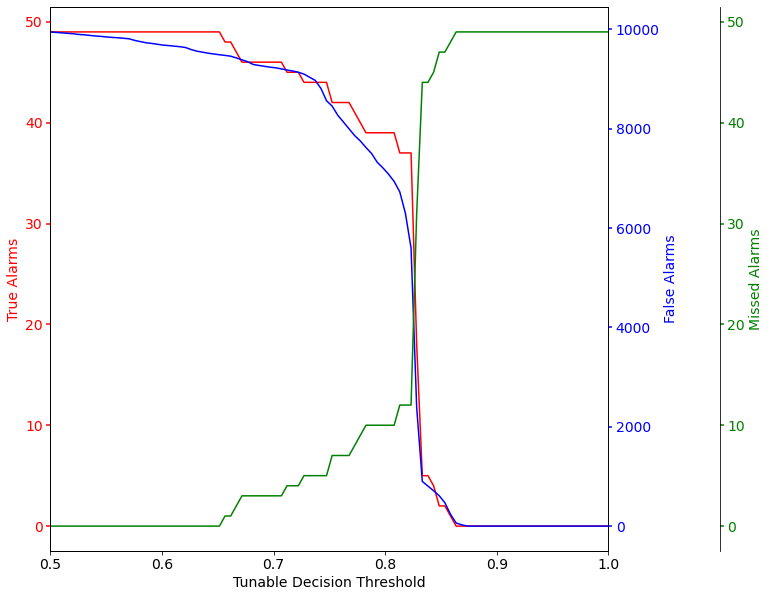

In [26]:
better_svm = SVC(probability=True, gamma=.01)
better_svm.fit(train_X, train_y)
train_probs = better_svm.predict_proba(train_X)
test_probs = better_svm.predict_proba(test_X)
plt.figure(figsize=(10, 10))
fpr, tpr, _ = roc_curve(test_y, test_probs[:, 1])
plt.plot(fpr, tpr, label='test')
fpr, tpr, _ = roc_curve(train_y, train_probs[:, 1])
plt.plot(fpr, tpr, label='train')
plt.legend()
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.plot([0, 1], [0, 1], 'k--')

unique_vals = {}
for c in subX.columns:
    unique_vals[c] = subX[c].unique()

probs_better_svc = better_svm.predict_proba(l)
true_labels_better_svc, max_probs_better_svc = easy_attack(probs_better_svc)

jim_plot(max_probs_better_svc[:N_CHECK], true_labels_better_svc)


This is a _much_ safer model. The attacker is wrong the vast majority of times that they make a prediction.

Note that they do still uncover 45 examples. This is simply because even guessing will be right sometimes (our student is randomly ticking multiple-choice answers). In a realistically sized problem, the chance of picking a real example at random is vanishingly small due to the enormous number of combinations.

We can see from the final plot that there isn't a region where the red line exceeds the blue.

### Other ML models

Black box attacks are not restricted to Support Vector Machines. Here we show exactly the same attack performed on another popular classifier, the Random Forest.


Tried 0 combinations. TP = 1, FP = 0
Tried 100 combinations. TP = 2, FP = 16
Tried 200 combinations. TP = 3, FP = 35
Tried 300 combinations. TP = 4, FP = 56
Tried 400 combinations. TP = 4, FP = 78
Tried 500 combinations. TP = 4, FP = 113
Tried 600 combinations. TP = 4, FP = 133
Tried 700 combinations. TP = 4, FP = 166
Tried 800 combinations. TP = 4, FP = 187
Tried 900 combinations. TP = 4, FP = 204
Tried 1000 combinations. TP = 4, FP = 231
Tried 1100 combinations. TP = 5, FP = 244
Tried 1200 combinations. TP = 5, FP = 272
Tried 1300 combinations. TP = 5, FP = 286
Tried 1400 combinations. TP = 5, FP = 301
Tried 1500 combinations. TP = 5, FP = 312
Tried 1600 combinations. TP = 6, FP = 323
Tried 1700 combinations. TP = 7, FP = 339
Tried 1800 combinations. TP = 10, FP = 357
Tried 1900 combinations. TP = 10, FP = 382
Tried 2000 combinations. TP = 10, FP = 408
Tried 2100 combinations. TP = 12, FP = 416
Tried 2200 combinations. TP = 13, FP = 437
Tried 2300 combinations. TP = 13, FP = 448
Trie

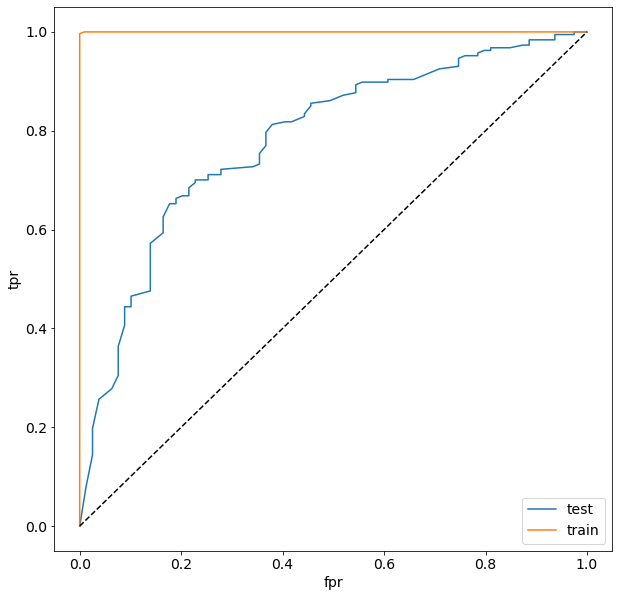

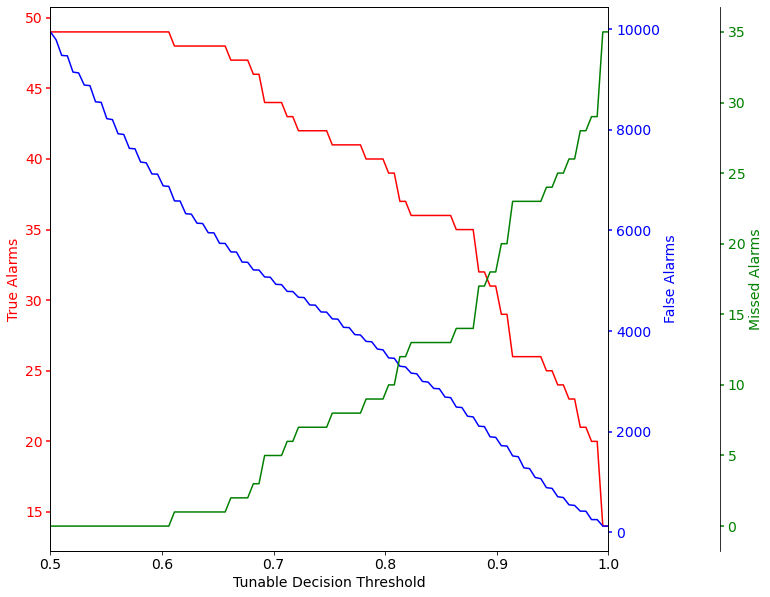

In [28]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(min_samples_split=2, min_samples_leaf=1)
rf.fit(train_X, train_y)
train_probs = rf.predict_proba(train_X)
test_probs = rf.predict_proba(test_X)
plt.figure(figsize=(10, 10))
fpr, tpr, _ = roc_curve(test_y, test_probs[:, 1])
plt.plot(fpr, tpr, label='test')
fpr, tpr, _ = roc_curve(train_y, train_probs[:, 1])
plt.plot(fpr, tpr, label='train')
plt.legend()
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.plot([0, 1], [0, 1], 'k--')

unique_vals = {}
for c in subX.columns:
    unique_vals[c] = subX[c].unique()

pred_probs = rf.predict_proba(l)
true_labels_rf, max_probs_rf = easy_attack(pred_probs)
jim_plot(max_probs_rf[:N_CHECK], true_labels_rf)